In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [2]:
# Load Cifar-10 data-set
(train_im, train_lab), (test_im, test_lab) = tf.keras.datasets.cifar10.load_data()


170500096/170498071 [==============================] - 2s 0us/step


In [3]:
#### Normalize the images to pixel values (0, 1)
train_im, test_im = train_im/255.0 , test_im/255.0
#### Check the format of the data 
print ("train_im, train_lab types: ", type(train_im), type(train_lab))
#### check the shape of the data
print ("shape of images and labels array: ", train_im.shape, train_lab.shape) 
print ("shape of images and labels array ; test: ", test_im.shape, test_lab.shape)

train_im, train_lab types:  <class 'numpy.ndarray'> <class 'numpy.ndarray'>
shape of images and labels array:  (50000, 32, 32, 3) (50000, 1)
shape of images and labels array ; test:  (10000, 32, 32, 3) (10000, 1)


In [4]:
#### Check the distribution of unique elements 
(unique, counts) = np.unique(train_lab, return_counts=True)

frequencies = np.asarray((unique, counts)).T

print (frequencies)
print (len(unique))

[[   0 5000]
 [   1 5000]
 [   2 5000]
 [   3 5000]
 [   4 5000]
 [   5 5000]
 [   6 5000]
 [   7 5000]
 [   8 5000]
 [   9 5000]]
10


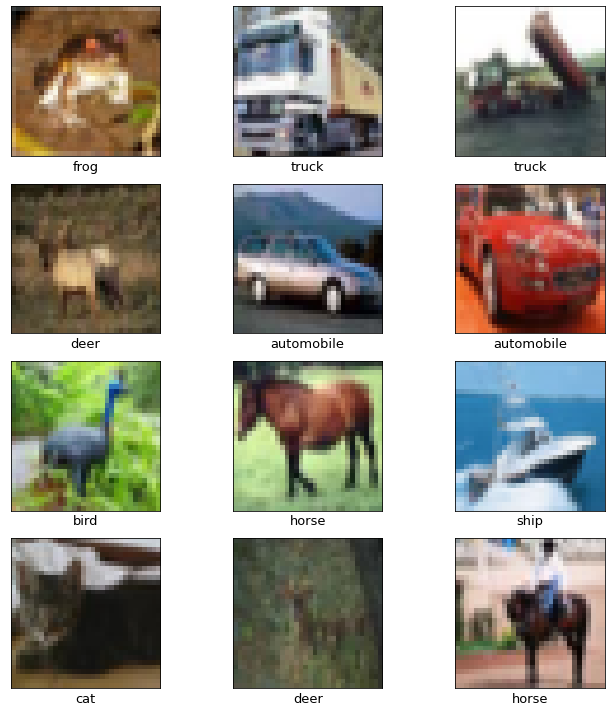

In [5]:
class_types = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck'] # from cifar-10 website

plt.figure(figsize=(10,10))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_im[i], cmap='gray')
    plt.xlabel(class_types[train_lab[i][0]], fontsize=13)
plt.tight_layout()    
plt.show()

In [6]:
### One hot encoding for labels 

train_lab_categorical = tf.keras.utils.to_categorical(
    train_lab, num_classes=10, dtype='uint8')

test_lab_categorical = tf.keras.utils.to_categorical(
    test_lab, num_classes=10, dtype='uint8')

In [7]:
### Train -test split 

from sklearn.model_selection import train_test_split 
train_im, valid_im, train_lab, valid_lab = train_test_split(train_im, train_lab_categorical, test_size=0.20, 
                                                            stratify=train_lab_categorical, 
                                                            random_state=40, shuffle = True)

print ("train data shape after the split: ", train_im.shape)
print ('new validation data shape: ', valid_im.shape)
print ("validation labels shape: ", valid_lab.shape)

train data shape after the split:  (40000, 32, 32, 3)
new validation data shape:  (10000, 32, 32, 3)
validation labels shape:  (10000, 10)


In [8]:
#### Necessary Imports for Neural Net 

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, ZeroPadding2D,\
     Flatten, BatchNormalization, AveragePooling2D, Dense, Activation, Add 
from tensorflow.keras.models import Model
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

In [9]:
##### Include Little Data Augmentation 
batch_size = 64 # try several values

train_DataGen = tf.keras.preprocessing.image.ImageDataGenerator(zoom_range=0.2, 
                                                                width_shift_range=0.1, 
                                                                height_shift_range = 0.1, 
                                                                horizontal_flip=True)
 
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

train_set_conv = train_DataGen.flow(train_im, train_lab, batch_size=batch_size) # train_lab is categorical 
valid_set_conv = valid_datagen.flow(valid_im, valid_lab, batch_size=batch_size) # so as valid_lab 

In [10]:
def res_identity(x, filters): 
  ''' renet block where dimension doesnot change.
  The skip connection is just simple identity conncection
  we will have 3 blocks and then input will be added
  '''
  x_skip = x # this will be used for addition with the residual block 
  f1, f2 = filters

  #first block 
  x = Conv2D(f1, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  #second block # bottleneck (but size kept same with padding)
  x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  # third block activation used after adding the input
  x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  # x = Activation(activations.relu)(x)

  # add the input 
  x = Add()([x, x_skip])
  x = Activation(activations.relu)(x)

  return x

In [11]:
def res_conv(x, s, filters):
  '''
  here the input size changes, when it goes via conv blocks
  so the skip connection uses a projection (conv layer) matrix
  ''' 
  x_skip = x
  f1, f2 = filters

  # first block
  x = Conv2D(f1, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x)
  # when s = 2 then it is like downsizing the feature map
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  # second block
  x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  #third block
  x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)

  # shortcut 
  x_skip = Conv2D(f2, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x_skip)
  x_skip = BatchNormalization()(x_skip)

  # add 
  x = Add()([x, x_skip])
  x = Activation(activations.relu)(x)

  return x

In [12]:
### Combine the above functions to build 50 layers resnet. 
def resnet50():

  input_im = Input(shape=(train_im.shape[1], train_im.shape[2], train_im.shape[3])) # cifar 10 images size
  x = ZeroPadding2D(padding=(3, 3))(input_im)

  # 1st stage
  # here we perform maxpooling, see the figure above

  x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)
  x = MaxPooling2D((3, 3), strides=(2, 2))(x)

  #2nd stage 
  # frm here on only conv block and identity block, no pooling

  x = res_conv(x, s=1, filters=(64, 256))
  x = res_identity(x, filters=(64, 256))
  x = res_identity(x, filters=(64, 256))

  # 3rd stage

  x = res_conv(x, s=2, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))

  # 4th stage

  x = res_conv(x, s=2, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))

  # 5th stage

  x = res_conv(x, s=2, filters=(512, 2048))
  x = res_identity(x, filters=(512, 2048))
  x = res_identity(x, filters=(512, 2048))

  # ends with average pooling and dense connection

  x = AveragePooling2D((2, 2), padding='same')(x)

  x = Flatten()(x)
  x = Dense(len(class_types), activation='softmax', kernel_initializer='he_normal')(x) #multi-class

  # define the model 

  model = Model(inputs=input_im, outputs=x, name='Resnet50')

  return model

In [13]:
### Define some Callbacks
def lrdecay(epoch):
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    #print('Learning rate: ', lr)
    return lr
  # if epoch < 40:
  #   return 0.01
  # else:
  #   return 0.01 * np.math.exp(0.03 * (40 - epoch))
lrdecay = tf.keras.callbacks.LearningRateScheduler(lrdecay) # learning rate decay  


def earlystop(mode):
  if mode=='acc':
    estop = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=15, mode='max')
  elif mode=='loss':
    estop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, mode='min')
  return estop    

In [14]:
resnet50_model = resnet50()

In [15]:
resnet50_model.summary()

Model: "Resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         conv2d[0][0]                     
___________________________________________________________________________________________

In [16]:
resnet50_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), 
                       metrics=['acc'])



In [17]:
#Callback function for saving checkpoints
from google.colab import drive
import os
drive.mount('/content/gdrive')

checkpoint_path = "/content/gdrive/My Drive/Colab Notebooks/checkpoints_renet1/training_batch_64_epochs300/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
print(checkpoint_dir)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    period=5)



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks/checkpoints_renet1/training_batch_64_epochs300


In [18]:
##For Loading the old model weights

'''
test_model = resnet50()
test_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), 
                       metrics=['acc'])

test_model.load_weights("/content/gdrive/My Drive/Colab Notebooks/checkpoints_renet1/training_batch64/cp-0160.ckpt")

loss, acc = test_model.evaluate(valid_im, valid_lab, verbose = 2)
'''

'\ntest_model = resnet50()\ntest_model.compile(loss=\'categorical_crossentropy\', optimizer=Adam(learning_rate=1e-3), \n                       metrics=[\'acc\'])\n\ntest_model.load_weights("/content/gdrive/My Drive/Colab Notebooks/checkpoints_renet1/training_batch64/cp-0160.ckpt")\n\nloss, acc = test_model.evaluate(valid_im, valid_lab, verbose = 2)\n'

In [21]:
#For running the model
batch_size=batch_size # test with 64, 128, 256
resnet50_model.save_weights(checkpoint_path.format(epoch=0))

resnet_train = resnet50_model.fit(train_set_conv, 
                                  epochs=1, 
                                  steps_per_epoch=train_im.shape[0]/batch_size, 
                                  validation_steps=valid_im.shape[0]/batch_size, 
                                  validation_data=valid_set_conv, 
                                  callbacks=[lrdecay, cp_callback])

625/625 [==============================] - 83s 133ms/step - loss: 0.8344 - acc: 0.7697 - val_loss: 1.1000 - val_acc: 0.6907 - lr: 0.0010


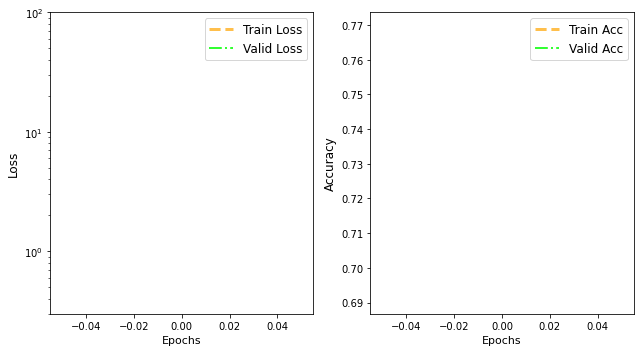

In [22]:
### Plot train and validation curves
loss = resnet_train.history['loss']
v_loss = resnet_train.history['val_loss']

acc = resnet_train.history['acc']
v_acc = resnet_train.history['val_acc']

epochs = range(len(loss))

fig = plt.figure(figsize=(9, 5))
plt.subplot(1, 2, 1)
plt.yscale('log')
plt.plot(epochs, loss, linestyle='--', linewidth=3, color='orange', alpha=0.7, label='Train Loss')
plt.plot(epochs, v_loss, linestyle='-.', linewidth=2, color='lime', alpha=0.8, label='Valid Loss')
plt.ylim(0.3, 100)
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.subplot(1, 2, 2)
plt.plot(epochs, acc, linestyle='--', linewidth=3, color='orange', alpha=0.7, label='Train Acc')
plt.plot(epochs, v_acc, linestyle='-.', linewidth=2, color='lime', alpha=0.8, label='Valid Acc') 
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('/content/gdrive/My Drive/Colab Notebooks/data_charts/train_acc.png', dpi=250)
plt.show()

In [27]:
#### Plot the Confusion Matrix

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def conf_matrix(predictions): 
    ''' Plots conf. matrix and classification report '''
    cm=confusion_matrix(test_lab, np.argmax(np.round(predictions), axis=1))
    print("Classification Report:\n")
    cr=classification_report(test_lab,
                                np.argmax(np.round(predictions), axis=1), 
                                target_names=[class_types[i] for i in range(len(class_types))])
    print(cr)
    plt.figure(figsize=(12,12))
    sns_hmp = sns.heatmap(cm, annot=True, xticklabels = [class_types[i] for i in range(len(class_types))], 
                yticklabels = [class_types[i] for i in range(len(class_types))], fmt="d")
    fig = sns_hmp.get_figure()
    fig.savefig('/content/gdrive/My Drive/Colab Notebooks/data_charts/resnet_heatmap.png', dpi=250)

Classification Report:

              precision    recall  f1-score   support

    airplane       0.37      0.78      0.50      1000
  automobile       0.85      0.78      0.81      1000
        bird       0.75      0.58      0.65      1000
         cat       0.89      0.17      0.28      1000
        deer       0.89      0.45      0.60      1000
         dog       0.60      0.75      0.67      1000
        frog       0.60      0.92      0.73      1000
       horse       0.82      0.74      0.78      1000
        ship       0.95      0.65      0.77      1000
       truck       0.74      0.86      0.80      1000

    accuracy                           0.67     10000
   macro avg       0.75      0.67      0.66     10000
weighted avg       0.75      0.67      0.66     10000



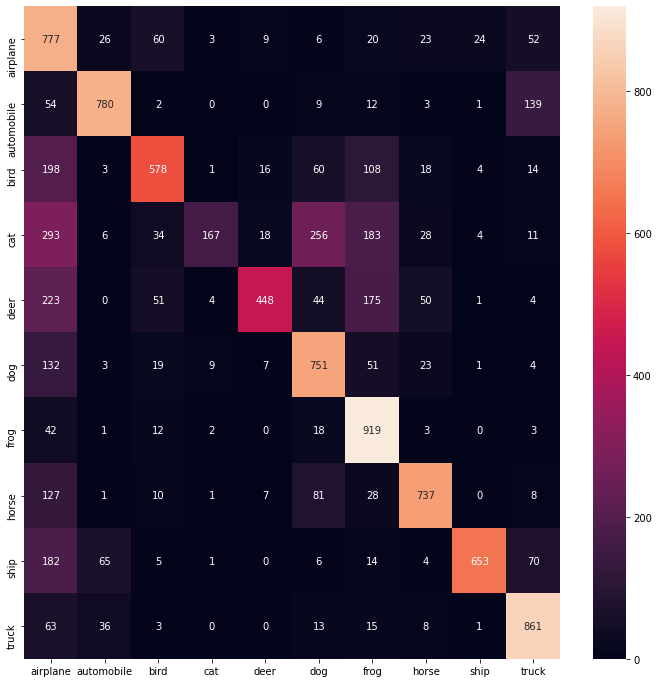

In [28]:
pred_class_resnet50 = resnet50_model.predict(test_im)

conf_matrix(pred_class_resnet50)

In [29]:
### Resutls on Test Data; 
## Check the performance on the test data 
test_result = resnet50_model.evaluate(test_im, test_lab_categorical, verbose=0)

print ("ResNet50 loss: ", test_result[0])
print ("ResNet50 accuracy: ", test_result[1])

ResNet50 loss:  1.0916383266448975
ResNet50 accuracy:  0.6963000297546387
